# Workshop: COVID-19 Pandemic and IHME Model
## Applied Math 115
## Santiago Giner, Lily Qian, Caleb Saul, Jing Xu

## 0. Initialization

In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import ode
from scipy.integrate import solve_ivp
import matplotlib.pylab as plt
from math import floor

### 0.1. Reading Data

In [2]:
# This code gives an example of how to read in the csv data and a template
# for the workshop

# change this to the path for your data
datapath = './';

# read in the state ID and state population
PopulationTable = pd.read_csv(datapath + 'US_states_population.csv');

# choose a state
stateid = 544

rowindex = PopulationTable.LocationID == stateid; #find the corresponding row
PopulationTable.StateName[rowindex] # state name
N = PopulationTable.Population[rowindex]; # total state population

In [3]:
# Read the data for a given state
def read_covid_data(filename,stateid):
    # read in the data as a table
    T = pd.read_csv(filename);
    rows = T.location_id == stateid;
    stateT = T[rows][['date','mean']]
    # Turn into a time table
#     data = table2timetable( stateT, 'RowTimes','Var1');
    stateT['date'] = pd.to_datetime(stateT['date'])
    stateT = stateT.set_index('date')
    return stateT

# Creating a function equivalent to ode45 in Matlab
def ode45(f, tint, y0, rtol=1e-9):
    r = ode(f).set_integrator('zvode', method='bdf',rtol=rtol)
    r.set_initial_value(y0, tint[0])
    dt = (tint[1] - tint[0]) / 10000
    t1 = tint[1]
    tt = []
    rr = []
    while r.successful() and r.t < t1:
        tt.append(r.t + dt)
        rr.append(np.real(r.integrate(r.t + dt)))
    return np.array(tt),np.array(rr)

In [4]:
# Read in daily infection, mobility and mask use
# using a function at the end of this file.
# You could choose to copy and paste that function into a separate file
dailyinfection = read_covid_data(datapath+'daily_infections.csv',stateid);
mobility = read_covid_data(datapath+'mobility.csv',stateid);
mask = read_covid_data(datapath+'mask_use.csv',stateid);

# synchronize the timetables so they line up in time
data = dailyinfection.join(mobility,how='outer',lsuffix='_dailyinfection',rsuffix='').join(mask,how='outer',lsuffix='_mobility',rsuffix='_mask');

# select the time range for the analysis
# the datasets contain data after 2020-09-21 but those are projections at
# the time the paper was written.
TR = pd.date_range('2020-02-01','2020-09-21');
data = data.loc[TR];

# ---------get your ODE solution here

# -----start the fit from March 11, 2020
# beta estimated very early in the pandemic may be subject to 
# large uncertainties, as imported cases may be important compared to
# community spread
mask = data.mean_mask[39:];
mobility = data.mean_mobility[39:];

In [5]:
data

mean_dailyinfection  mean_mobility  mean_mask
2020-02-01             0.330424       1.343770   0.000364
2020-02-02             0.320982      -0.374706   0.000457
2020-02-03             0.315569      -1.883808   0.000575
2020-02-04             0.314699      -3.032464   0.000722
2020-02-05             0.319001      -3.731245   0.000907
...                         ...            ...        ...
2020-09-17          1107.258990     -30.832502   0.427701
2020-09-18          1112.084051     -30.778139   0.432005
2020-09-19          1117.555183     -30.744608   0.436100
2020-09-20          1123.111741     -30.724417   0.439960
2020-09-21          1128.806576     -30.711387   0.443565

[234 rows x 3 columns]

## 1. Building the Model

### 1.1. Model Parameters and Equations

In [6]:
# Define constants
alpha = 0.95
sigma = 0.25
gamma1 = 0.5
gamma2 = 2 / 3

In [7]:
# Define f(t) function
f = lambda t: data["mean_dailyinfection"][floor(t)]

# Define system of equations
def ode_system(t, values):
    # Get values of each variable
    S, E, I1, I2, R = values
    # Define time derivatives
    dS_dt = -f(t)
    dE_dt = f(t) - sigma * E
    dI1_dt = sigma * E - gamma1 * I1
    dI2_dt = gamma1 * I1 - gamma2 * I2
    dR_dt = gamma2 * I2
    # Return time derivatives
    return dS_dt, dE_dt, dI1_dt, dI2_dt, dR_dt

In [8]:
# Initial values of variables and time to integrate over
vals0 = [int(N), 0, 0, 0, 0]
t = [0, 233]

# Solve the system of equations
sol = solve_ivp(ode_system, t, vals0)

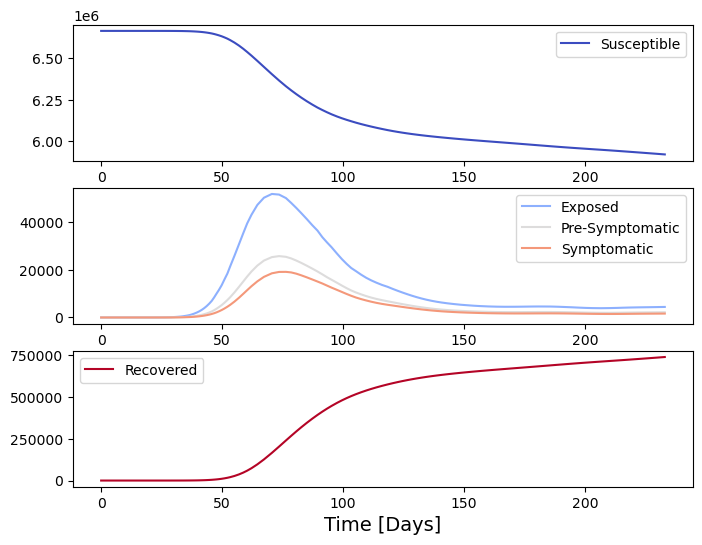

In [40]:
labels = ["Susceptible", "Exposed", "Pre-Symptomatic", "Symptomatic", "Recovered"]
colors = plt.cm.coolwarm(np.linspace(0, 1, 5))
fig, ax = plt.subplots(3, 1, figsize=(8, 6))

# Susceptible
ax[0].plot(sol.t, sol.y[0], label=labels[0], color=colors[0])
ax[0].legend()

# Exposed, pre-symptomatic, and symptomatic
for i in range(1, 4):
    ax[1].plot(sol.t, sol.y[i], label=labels[i], color=colors[i])
ax[1].legend()

# Recovered
ax[2].plot(sol.t, sol.y[4], label=labels[-1], color=colors[-1])
ax[2].set_xlabel("Time [Days]", fontsize=14)
ax[2].legend()
plt.show()

### 1.2. Finding $\beta(t)$

In [36]:
# Find beta(t)
# Start indec determined empirically because initial betas are astronomical
start_index = 12
f_sol = np.array([f(t) for t in sol.t[start_index:]])
S_sol = sol.y[0][start_index:]
I1_sol = sol.y[2][start_index:]
I2_sol = sol.y[3][start_index:]
beta = int(N) * f_sol / (S_sol * (I1_sol + I2_sol))**alpha

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(sol.t[start_index:], beta)
ax.set_xlabel("Time [Days]", fontsize=14)
ax.set_ylabel(r"$\beta$", fontsize=14)
ax.set_title("Spread Rate, State: Massachusetts", fontsize=16)
plt.show()

## 2. Effect of Mobility and Mask Use on $\beta(t)$

### 2.1. Linear Regression on $\log(\beta(t))$

In [47]:
# TODO

### 2.2. Assumptions
TODO

### 2.3 Discussion
TODO